In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer

In [3]:
from sklearn.cluster import KMeans

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [5]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
print(train.isnull().sum().sort_values(ascending=False).head(20))

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Condition2         0
dtype: int64


In [8]:
print(test.isnull().sum().sort_values(ascending=False).head(35))

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageCond        78
GarageFinish      78
GarageQual        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF1         1
Exterior1st        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
SaleType           1
KitchenQual        1
GarageCars         1
GarageArea         1
Exterior2nd        1
Condition2         0
Condition1         0
dtype: int64


In [9]:
# Data clean
# missing values 
# high_missing_cols fill with 'None'
high_missing_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']
for col in high_missing_cols:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

# middle_missing_cols fill with 'None' except LotFrontage
for col in ['MasVnrType', 'FireplaceQu']:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

# low missing（except MSZoning）
zero_fill_cols = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
for col in zero_fill_cols:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)
#categories and garagecars,garagearea
cat_cols = ['Electrical', 'Utilities', 'Functional', 'Exterior1st', 'Exterior2nd', 'SaleType', 'KitchenQual',
            'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType1', 'BsmtFinType2','GarageCars', 'GarageArea']
for col in cat_cols:
    train[col] = train[col].fillna(train[col].mode()[0])
    test[col] = test[col].fillna(test[col].mode()[0])
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0)
garage_cols = ['GarageQual', 'GarageFinish', 'GarageType', 'GarageCond']
for col in garage_cols:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')


# KNN fill LotFrontage and MSZoning
knn_cols = ['LotFrontage', 'MSZoning']
related_cols = ['GrLivArea', 'LotArea', 'OverallQual', 'Neighborhood']
combined = pd.concat([train[knn_cols + related_cols], test[knn_cols + related_cols]], axis=0)
label_encoders = {}
for col in ['MSZoning', 'Neighborhood']:
    le = LabelEncoder()
    combined[col] = combined[col].fillna('Missing')
    combined[col] = le.fit_transform(combined[col])
    label_encoders[col] = le
scaler = StandardScaler()
num_cols = ['LotFrontage', 'GrLivArea', 'LotArea', 'OverallQual']
combined[num_cols] = scaler.fit_transform(combined[num_cols])
imputer = KNNImputer(n_neighbors=5, weights='distance')
combined_imputed = pd.DataFrame(imputer.fit_transform(combined), columns=combined.columns)
combined_imputed[num_cols] = scaler.inverse_transform(combined_imputed[num_cols])
combined_imputed['MSZoning'] = label_encoders['MSZoning'].inverse_transform(combined_imputed['MSZoning'].round().astype(int))
combined_imputed['Neighborhood'] = label_encoders['Neighborhood'].inverse_transform(combined_imputed['Neighborhood'].round().astype(int))
train[knn_cols] = combined_imputed.iloc[:train.shape[0], :][knn_cols]
test[knn_cols] = combined_imputed.iloc[:test.shape[0], :][knn_cols]

# validate missing values
print("Train missing values:\n", train.isnull().sum().sort_values(ascending=False).head(5))
print("Test missing values:\n", test.isnull().sum().sort_values(ascending=False).head(5))

Train missing values:
 Id             0
MSSubClass     0
MSZoning       0
LotFrontage    0
LotArea        0
dtype: int64
Test missing values:
 Id             0
MSSubClass     0
MSZoning       0
LotFrontage    0
LotArea        0
dtype: int64


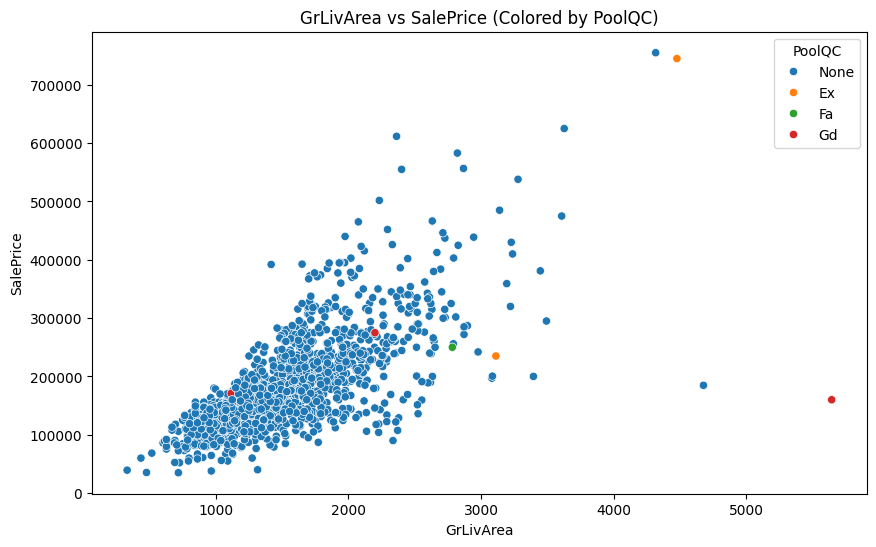

Train shape after outlier removal: (1456, 81)


In [10]:
# outlier removal
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', hue='PoolQC', data=train)
plt.title('GrLivArea vs SalePrice (Colored by PoolQC)')
plt.show()
train = train[train['GrLivArea'] < 4000]
train = train[train['SalePrice'] < 700000]
print("Train shape after outlier removal:", train.shape)



In [11]:
# transform categorical columns to string
cat_cols = ['MSSubClass', 'OverallQual', 'OverallCond', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MSZoning']
train[cat_cols] = train[cat_cols].astype(str)
test[cat_cols] = test[cat_cols].astype(str)

In [12]:
# save cleaned data
train.to_csv('train_cleaned_knn.csv', index=False)
test.to_csv('test_cleaned_knn.csv', index=False)
print("Train shape after cleaning:", train.shape)
print("Test shape after cleaning:", test.shape)



Train shape after cleaning: (1456, 81)
Test shape after cleaning: (1459, 80)


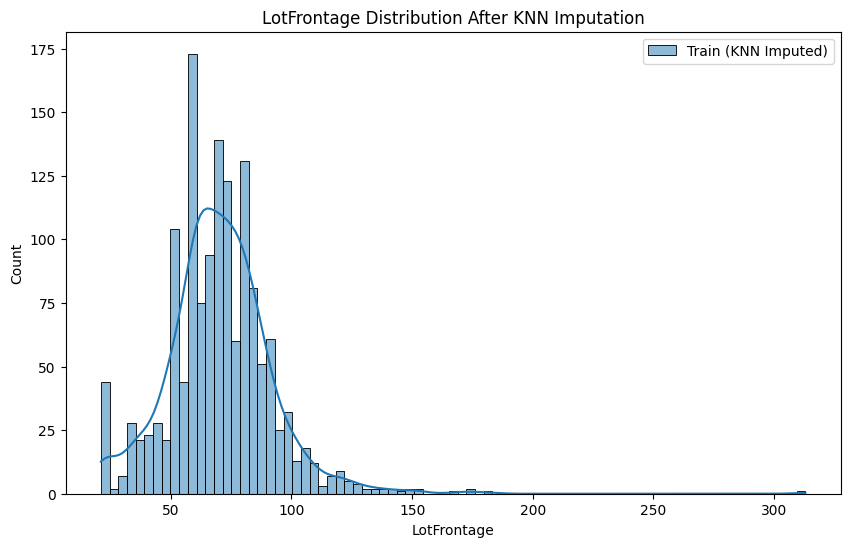

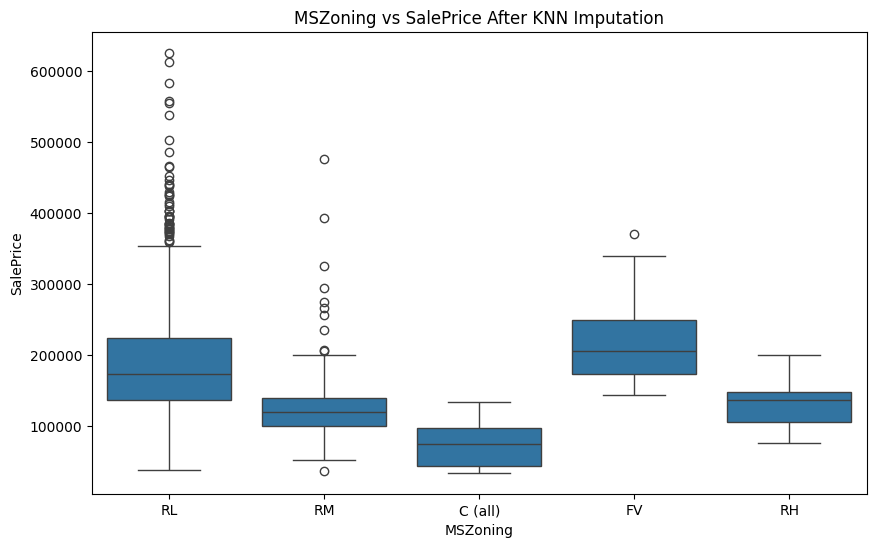

In [13]:
# validate KNN imputation effect
plt.figure(figsize=(10, 6))
sns.histplot(train['LotFrontage'], kde=True, label='Train (KNN Imputed)')
plt.title('LotFrontage Distribution After KNN Imputation')
plt.legend()
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(x='MSZoning', y='SalePrice', data=train)
plt.title('MSZoning vs SalePrice After KNN Imputation')
plt.show()

In [14]:

#Feature engineering
# load cleaned data
train1 = pd.read_csv('train_cleaned_knn.csv',keep_default_na=False).set_index('Id') 
#keep_default_na=False to avoid NaN issues, important
#set_index('Id') to exclude id column, important
test1 = pd.read_csv('test_cleaned_knn.csv',keep_default_na=False).set_index('Id') 
#keep_default_na=False to avoid NaN issues, important
#set_index('Id') to exclude id column, important

# combine datasets for feature engineering consistency
train1['is_train'] = 1
test1['is_train'] = 0
combined = pd.concat([train1.drop('SalePrice', axis=1), test1], axis=0)


In [15]:
# 1. create new features
# total area (above ground + basement)
combined['TotalSF'] = combined['TotalBsmtSF'] + combined['1stFlrSF'] + combined['2ndFlrSF']

# house age (year sold - year built)
combined['HouseAge'] = combined['YrSold'] - combined['YearBuilt']

# renewal age (year sold - year remodeled)
combined['RemodAge'] = combined['YrSold'] - combined['YearRemodAdd']

# total bathroom count (above ground + basement)
combined['TotalBath'] = combined['FullBath'] + 0.5 * combined['HalfBath'] + \
                       combined['BsmtFullBath'] + 0.5 * combined['BsmtHalfBath']

# total rooms (excluding bathrooms)
combined['TotalRooms'] = combined['TotRmsAbvGrd'] + combined['BedroomAbvGr']

# garage age (if no garage, fill 0)
combined['GarageAge'] = combined['YrSold'] - combined['GarageYrBlt'].fillna(0)

# swimming pool, fence, miscellaneous features
combined['HasPool'] = combined['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
combined['HasFence'] = combined['Fence'].apply(lambda x: 1 if x != 'None' else 0)
combined['HasMisc'] = combined['MiscFeature'].apply(lambda x: 1 if x != 'None' else 0)

# additional features
combined['SF_Qual'] = combined['TotalSF'] * combined['OverallQual']
combined['LivArea_Bedroom'] = combined['GrLivArea'] * combined['BedroomAbvGr']

# season feature
def get_season(month):
    if month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    elif month in [9, 10, 11]: return 'Fall'
    else: return 'Winter'
combined['Season'] = combined['MoSold'].apply(get_season)


In [16]:
combined['FireplaceQu'].nunique()
combined['FireplaceQu'].unique()

array(['None', 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [17]:
combined['ExterQual'].unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

In [18]:
# 2. categorical encoding
# ordinal variable mapping
ordinal_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 
                'BsmtExposure', 'Functional','PoolQC']
quality_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0, 'NA': 0 }
bsmt_exposure_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1,  'NA': 0}
functional_map = {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 
                  'Maj2': 3, 'Sev': 2, 'Sal': 1}
PoolQC_map = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'None': 0}
for col in ordinal_cols:
    if col == 'BsmtExposure':
        combined[col] = combined[col].map(bsmt_exposure_map)
    elif col == 'Functional':
        combined[col] = combined[col].map(functional_map)
    elif col == 'PoolQC':
        combined[col] = combined[col].map(PoolQC_map)
    else:
        combined[col] = combined[col].map(quality_map)

In [19]:
# label encoding 
nominal_cols = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
                'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 
                'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
                'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1', 
                'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 
                'GarageFinish', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 
                'SaleCondition', 'Season']
label_encoders = {}
for col in nominal_cols:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col])
    label_encoders[col] = le

# encoding Neighborhood
neighborhood_mean = train1.groupby('Neighborhood')['SalePrice'].mean()
combined['Neighborhood_MeanPrice'] = combined['Neighborhood'].map(neighborhood_mean)
combined['Neighborhood_MeanPrice'] = combined['Neighborhood_MeanPrice'].fillna(neighborhood_mean.mean())

# 3. clustering
cluster_features = ['TotalSF', 'OverallQual', 'GrLivArea']
kmeans = KMeans(n_clusters=5, random_state=42)
combined['Cluster'] = kmeans.fit_predict(combined[cluster_features])

# 4. delete low information columns
low_info_cols = ['LowQualFinSF', 'MiscVal', 'PoolArea']
combined = combined.drop(low_info_cols, axis=1)

# 5. deal with skewness
# log transform SalePrice
train1['SalePrice'] = np.log1p(train1['SalePrice'])

# transform skewed numeric features when skewness > 0.75
colums_to_drop = ['is_train'] + nominal_cols
numeric_cols = combined.select_dtypes(include=[np.number]).columns.drop(colums_to_drop)
skewed_cols = combined[numeric_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
skewed_cols = skewed_cols[abs(skewed_cols) > 0.75].index
for col in skewed_cols:
    combined[col] = np.log1p(combined[col].clip(lower=0))

# 6. standardize numeric features
scaler = StandardScaler()
combined[numeric_cols] = scaler.fit_transform(combined[numeric_cols])

# 7. separate train and test sets
train_processed = combined[combined['is_train'] == 1].drop('is_train', axis=1)
test_processed = combined[combined['is_train'] == 0].drop('is_train', axis=1)
train_processed['SalePrice'] = train1['SalePrice']

# 8. validate feature engineering
print("New features created:", ['TotalSF', 'HouseAge', 'RemodAge', 'TotalBath', 
                              'TotalRooms', 'GarageAge', 'HasPool', 'HasFence', 
                              'HasMisc', 'SF_Qual', 'LivArea_Bedroom', 
                              'Neighborhood_MeanPrice', 'Season', 'Cluster'])
print("Train processed shape:", train_processed.shape)
print("Test processed shape:", test_processed.shape)
print("Missing values in train:", train_processed.isnull().sum().max())
print("Missing values in test:", test_processed.isnull().sum().max())

# save processed data
train_processed.to_csv('train_processed.csv', index=False)
test_processed.to_csv('test_processed.csv', index=False)

New features created: ['TotalSF', 'HouseAge', 'RemodAge', 'TotalBath', 'TotalRooms', 'GarageAge', 'HasPool', 'HasFence', 'HasMisc', 'SF_Qual', 'LivArea_Bedroom', 'Neighborhood_MeanPrice', 'Season', 'Cluster']
Train processed shape: (1456, 91)
Test processed shape: (1459, 90)
Missing values in train: 0
Missing values in test: 0


In [20]:
print(train_processed.isnull().sum().sort_values(ascending=False).head(5))

MSSubClass     0
MSZoning       0
LotFrontage    0
LotArea        0
Street         0
dtype: int64


In [21]:
print(test_processed.isnull().sum().sort_values(ascending=False).head(5))

MSSubClass     0
MSZoning       0
LotFrontage    0
LotArea        0
Street         0
dtype: int64


In [22]:
#model training, base models
train_processed = pd.read_csv('train_processed.csv')
test_processed = pd.read_csv('test_processed.csv')

# define features and target variable
X = train_processed.drop(['SalePrice'], axis=1)
y = train_processed['SalePrice']  # log transformed
X_test = test_processed.copy()

# split train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# default  base models
# random forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))
print(f"RandomForest RMSE: {rf_rmse:.5f}")

# XGBoost
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
print(f"XGBoost RMSE: {xgb_rmse:.5f}")

# LightGBM
lgb = LGBMRegressor(random_state=42)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_val)
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_pred))
print(f"LightGBM RMSE: {lgb_rmse:.5f}")

# CatBoost
# define categorical features for CatBoost
categorical_features = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 
                       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 
                       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
                       'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1', 
                       'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 
                       'GarageFinish', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 
                       'SaleCondition', 'Season']

# train CatBoost
catboost = CatBoostRegressor(cat_features=categorical_features, random_state=42, verbose=0)
catboost.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

# evaluate CatBoost
catboost_pred = catboost.predict(X_val)
catboost_rmse = np.sqrt(mean_squared_error(y_val, catboost_pred))
print(f"CatBoost RMSE: {catboost_rmse:.5f}")



RandomForest RMSE: 0.14798
XGBoost RMSE: 0.14340
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4347
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 83
[LightGBM] [Info] Start training from score 12.028422
LightGBM RMSE: 0.14047
CatBoost RMSE: 0.12252


In [27]:
# train CatBoost
catboost = CatBoostRegressor(cat_features=categorical_features, random_state=42, verbose=0)
catboost.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=200)

# evaluate CatBoost
catboost_pred = catboost.predict(X_val)
catboost_rmse = np.sqrt(mean_squared_error(y_val, catboost_pred))
print(f"CatBoost RMSE: {catboost_rmse:.5f}")

CatBoost RMSE: 0.12006


In [24]:
# xgboost hyperparameter tuning
# XGBoost parameter grid
xgb_param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# grid search for hyperparameter tuning
xgb = XGBRegressor(random_state=42)
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# output best parameters and score
print("best XGBoost params:", xgb_grid.best_params_)
print("best XGBoost RMSE:", -xgb_grid.best_score_)

# validate tuned XGBoost model
xgb_best = xgb_grid.best_estimator_
xgb_pred = xgb_best.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
print(f"Hyperparameter tuned XGBoost RMSE: {xgb_rmse:.5f}")

best XGBoost params: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.8}
best XGBoost RMSE: 0.1165150529790833
Hyperparameter tuned XGBoost RMSE: 0.12209


In [ ]:
#lgbm hyperparameter tuning
lgb_param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 31, 63],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# grid search for hyperparameter tuning
lgb = LGBMRegressor(random_state=42)
lgb_grid = GridSearchCV(lgb, lgb_param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgb_grid.fit(X_train, y_train)

# output best parameters and score
print("Best LightGBM params:", lgb_grid.best_params_)
print("Best LightGBM RMSE:", -lgb_grid.best_score_)

# validate tuned LGBM model
lgb_best = lgb_grid.best_estimator_
lgb_pred = lgb_best.predict(X_val)
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_pred))
print(f"Hyperparameter tuned LightGBM RMSE: {lgb_rmse:.5f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4347
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 83
[LightGBM] [Info] Start training from score 12.028422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [28]:
# CatBoost hyperparameter tuning
catboost_param_grid = {
    'iterations': [500],
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1],
    'border_count': [32, 64, 128]
}
catboost = CatBoostRegressor(cat_features=categorical_features, random_state=42, verbose=0)
catboost_grid = RandomizedSearchCV(catboost, catboost_param_grid, n_iter=50, cv=5, 
                                  scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)
catboost_grid.fit(X_train, y_train)
print("Best CatBoost params:", catboost_grid.best_params_)
print("Best CatBoost RMSE:", -catboost_grid.best_score_)

# 验证集评估
best_params = catboost_grid.best_params_.copy()
best_params['iterations'] = 5000
catboost_best = CatBoostRegressor(**best_params, cat_features=categorical_features, 
                                  random_state=42, verbose=100)
catboost_best.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=200)
#catboost_best = catboost_grid.best_estimator_  Not use best params directly, set iterations to 5000
catboost_pred = catboost_best.predict(X_val)
catboost_rmse = np.sqrt(mean_squared_error(y_val, catboost_pred))
print(f"Hyperparameter tuned CatBoost RMSE: {catboost_rmse:.5f}")

Best CatBoost params: {'learning_rate': 0.03, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 6, 'border_count': 64, 'bagging_temperature': 0.5}
Best CatBoost RMSE: 0.11541428573327721
0:	learn: 0.3865611	test: 0.3909385	best: 0.3909385 (0)	total: 42.9ms	remaining: 3m 34s
100:	learn: 0.1213353	test: 0.1431329	best: 0.1431329 (100)	total: 5.01s	remaining: 4m 3s
200:	learn: 0.0937983	test: 0.1255426	best: 0.1255426 (200)	total: 9.93s	remaining: 3m 57s
300:	learn: 0.0805938	test: 0.1218724	best: 0.1218724 (300)	total: 14.9s	remaining: 3m 52s
400:	learn: 0.0717797	test: 0.1206396	best: 0.1205366 (394)	total: 19.9s	remaining: 3m 48s
500:	learn: 0.0656199	test: 0.1199625	best: 0.1199496 (499)	total: 25s	remaining: 3m 44s
600:	learn: 0.0600158	test: 0.1196373	best: 0.1196026 (592)	total: 30s	remaining: 3m 39s
700:	learn: 0.0559097	test: 0.1196370	best: 0.1196026 (592)	total: 35s	remaining: 3m 34s
800:	learn: 0.0520012	test: 0.1194539	best: 0.1194192 (725)	total: 40s	remaining: 3m 29s
900:	learn

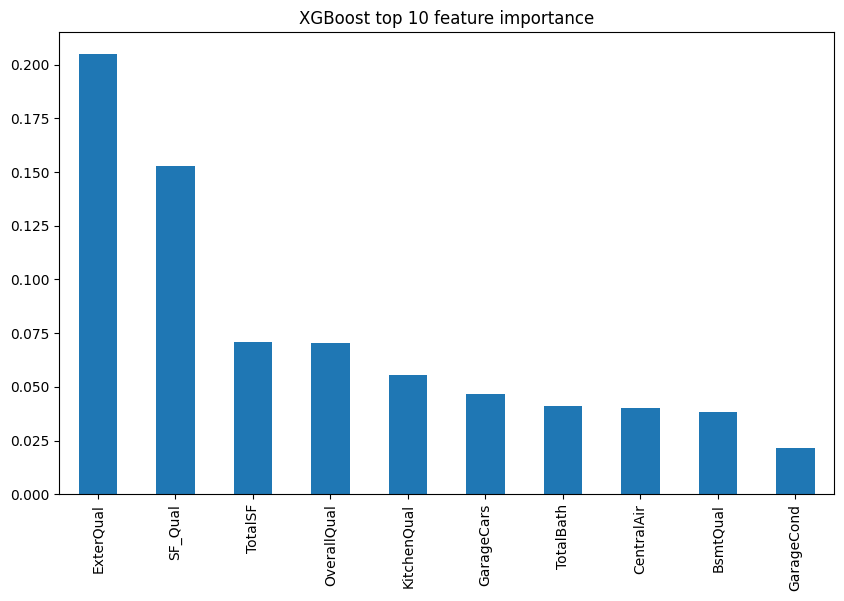

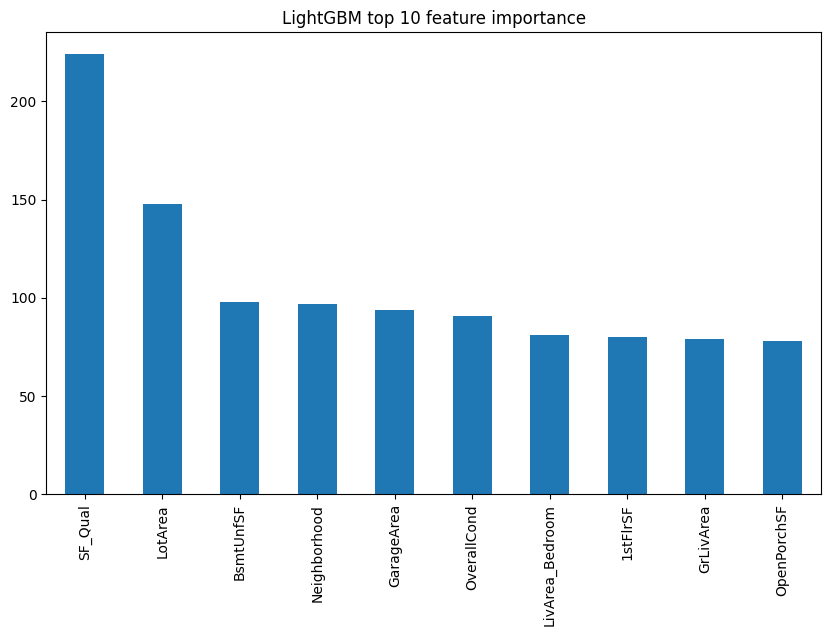

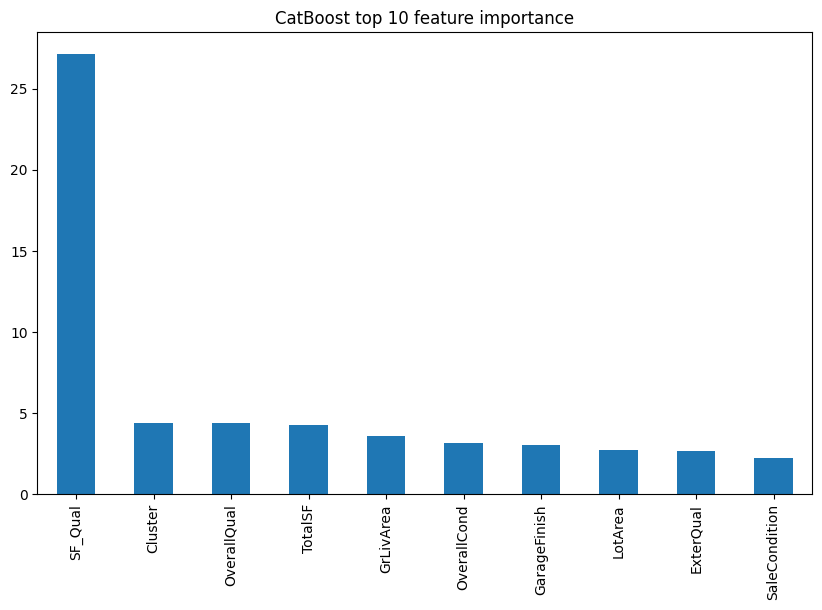

In [29]:
# feature importance visualization
# XGBoost feature importance
xgb_importance = pd.Series(xgb_best.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
xgb_importance[:10].plot(kind='bar')
plt.title('XGBoost top 10 feature importance')
plt.show()

# LightGBM feature importance
lgb_importance = pd.Series(lgb_best.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
lgb_importance[:10].plot(kind='bar')
plt.title('LightGBM top 10 feature importance')
plt.show()

# CatBoost feature importance
catboost_importance = pd.Series(catboost_best.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
catboost_importance[:10].plot(kind='bar')
plt.title('CatBoost top 10 feature importance')
plt.show()

In [30]:
# XGBoost cross-validation
xgb_cv_scores = cross_val_score(xgb_best, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"XGBoost cross-validation RMSE: {-xgb_cv_scores.mean():.5f} (+/- {xgb_cv_scores.std() * 2:.5f})")

# LightGBM cross-validation
lgb_cv_scores = cross_val_score(lgb_best, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"LightGBM cross-validation RMSE: {-lgb_cv_scores.mean():.5f} (+/- {lgb_cv_scores.std() * 2:.5f})")

# CatBoost cross-validation
catboost_cv_scores = cross_val_score(catboost_best, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"CatBoost cross-validation RMSE: {-catboost_cv_scores.mean():.5f} (+/- {catboost_cv_scores.std() * 2:.5f})")

XGBoost cross-validation RMSE: 0.11515 (+/- 0.01515)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4328
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 82
[LightGBM] [Info] Start training from score 12.018763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [31]:
# predict on test set
xgb_test_pred = xgb_best.predict(X_test)
lgb_test_pred = lgb_best.predict(X_test)
catboost_test_pred = catboost_best.predict(X_test)

# simple ensemble (average predictions)
final_pred = (xgb_test_pred + lgb_test_pred + catboost_test_pred) / 3

# expm1 transformation to reverse log transformation
final_pred = np.expm1(final_pred)

# save submission file
submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': final_pred})
submission.to_csv('submission_baseline.csv', index=False)

In [33]:
# define base models for stacking
base_models = [
    ('rf', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(**xgb_grid.best_params_, random_state=42)),
    ('lgb', LGBMRegressor(**lgb_grid.best_params_, random_state=42)),
    ('catboost', CatBoostRegressor(**catboost_grid.best_params_, cat_features=categorical_features, random_state=42, verbose=0))
]

# define meta learner
# meta_learner = Ridge()
# first try use normal parameters for LGBMRegressor
meta_learner = LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, 
                              num_leaves=15, random_state=42)
# initia Stacking
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_learner, cv=5)

# train Stacking model
stacking_model.fit(X_train, y_train)

# validate Stacking model
stacking_pred = stacking_model.predict(X_val)
stacking_rmse = np.sqrt(mean_squared_error(y_val, stacking_pred))
print(f"Stacking RMSE: {stacking_rmse:.5f}")

# cross-validation
stacking_cv_scores = cross_val_score(stacking_model, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"Stacking cross-validation RMSE: {-stacking_cv_scores.mean():.5f} (+/- {stacking_cv_scores.std() * 2:.5f})")

# predict on test set
stacking_test_pred = stacking_model.predict(X_test)
stacking_test_pred = np.expm1(stacking_test_pred)

# save submission file
submission_stacking = pd.DataFrame({'Id': test['Id'], 'SalePrice': stacking_test_pred})
submission_stacking.to_csv('submission_stacking.csv', index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4347
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 83
[LightGBM] [Info] Start training from score 12.028422
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4328
[LightGBM] [Info] Number of data points in the train set: 1164, number of used features: 82
[LightGBM] [Info] Start training from score 12.018763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4338
[LightGBM] [Info] Number of data points in the train set: 1165, number of used features: 83
[LightGBM] [Info] Start training from score 12.020740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4342
[LightGBM] [Info] Number of data points in the train set: 1165, number of used features: 84
[LightGBM] [Info] Start training from score 12.019390
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4245
[LightGBM] [Info] Number of data points in the train set: 1165, number of used features: 82
[LightGBM] [Info] Start training from score 12.030376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4341
[LightGBM] [Info] Number of data points in the train set: 1165, number of used features: 84
[LightGBM] [Info] Start training from score 12.020475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\Liuji\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
